## Import Libraries, set default paths and default colors for plots

In [51]:
# # generalimport pymc
import os
import sys
import glob
import datetime
import shutil

# EXTERNAL DEPENDENCIES
import numpy as np
import pandas as pd
import pickle as pk
from tqdm.notebook import tqdm
from multiprocessing import Pool

# sound processing
from soundsig.sound import BioSound, spec_colormap, WavFile

# Statistics
from scipy.stats import norm, chi2, zscore
# from pymer4.models import Lmer # not in the Semantic environment
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
# import scipy.stats
# from sklearn.metrics import accuracy_score
# from soundsig.sound import spectrogram, plot_spectrogram

# Plotting
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# path to library - Change to place of where you downloaded the library from FigShare (https://doi.org/10.6084/m9.figshare.11905533.v1)
path2Library = os.path.expanduser('/Volumes/auto/zdrive/julie/ZebraFinchVocalizationBank/')

# The directory for storing calculation data - Change to place of your choice
outpath = os.path.expanduser('/Volumes/auto/zdrive/julie/ZebraFinchVocalizationBank_features/')
if not os.path.isdir(outpath):
    os.mkdir(outpath)
    
# The diretory for saving figures - Change to place of your choice
# figDir = os.path.expanduser('~/Google\Drive/My\Drive/ZFProjects/Julie\CallType\Behavior')

# The directory where the metadata of this notebook are saved
RESULTSDIR = '../data/acoustic'
SAVEDIR = '../data/acoustic_confusion/' # Directory to save lda results



# Set colors for call-types in plots
call_type_colors = { 'TE':(140/255.0, 100/255.0, 185/255.0),
                    'DC': '#9bcd7b',
                    'TH':(255/255.0, 150/255.0, 40/255.0),}

# The standard color table of Etho Call-types
callColor = {
        'Be':(0/255.0, 230/255.0, 255/255.0),
        'BE':(0/255.0, 230/255.0, 255/255.0),
        'Tu':(255/255.0, 200/255.0, 65/255.0),
        'TU':(255/255.0, 200/255.0, 65/255.0),
        'Th':(255/255.0, 150/255.0, 40/255.0),
        'TH':(255/255.0, 150/255.0, 40/255.0),
        'Alarm':(255/255.0, 200/255.0, 65/255.0),
        'Di':(255/255.0, 105/255.0, 15/255.0),
        'DI':(255/255.0, 105/255.0, 15/255.0),
        'Ag':(255/255.0, 0/255.0, 0/255.0),
        'AG':(255/255.0, 0/255.0, 0/255.0),
        'Fight':(255/255.0, 105/255.0, 15/255.0),
        'Wh':(255/255.0, 180/255.0, 255/255.0),
        'WH':(255/255.0, 180/255.0, 255/255.0),
        'Ne':(255/255.0, 100/255.0, 255/255.0),
        'NE':(255/255.0, 100/255.0, 255/255.0),
        'Te':(140/255.0, 100/255.0, 185/255.0),
        'TE':(140/255.0, 100/255.0, 185/255.0),
        'Soft':(255/255.0, 180/255.0, 255/255.0),
        'DC':(100/255.0, 50/255.0, 200/255.0),
        'LT':(0/255.0, 95/255.0, 255/255.0),
        'Loud':(100/255.0, 50/255.0, 200/255.0),
        'song':(0, 0, 0),
        'So':(0,0,0), 
        'SO':(0,0,0),
        'In': (0.49,0.60,0.55), 
        'Mo':(0.69,0.39,0.39),
        'Ri':(0,255/255.0,0),
        'WC': (.25, .25, .25)}

## Gather the list of filenames and vocalizations details for DC, Te and Th in the database (SKIP IF YOU DON'T HAVE THE DATABASE)

In [3]:
directory = (glob.glob(path2Library + "*Vocalizations"))

# initialize output
filepaths  = []
filenames = []
birdnames = []
calltypes = []
renditions = []
birdage = []


# loop to gather filenames, bird names...
for d in directory :
    filespath_local = (glob.glob(d + "/*.wav"))
    for f in filespath_local :
        name = os.path.split(f)[-1]
        separator_ = name.split('_')
        if len(separator_)==2:
            calltype_local = separator_[1][7:9]
            
        elif len(separator_)==3:
            calltype_local = name[18:20]

        if (calltype_local == 'DC') | (calltype_local == 'Te') | (calltype_local == 'Th'):
            calltypes.append(calltype_local)
            filenames.append(name)
            filepaths.append(f)
            birdnames.append(separator_[0])
            if 'Adult' in d:
                birdage.append('A')
            else:
                birdage.append('C')
            separator2 = name.split('-')
            renditions.append(separator2[-1][0:2])


In [4]:
NVoc = len(filepaths)
print(f"total number of sound files in the bank: {NVoc}")

total number of sound files in the bank: 0


In [5]:
# verify that we have gathered calltypes of interest
set(calltypes)

set()

## Calculating spectrograms for all the selected vocalizations (SKIP IF YOU DON'T HAVE THE DATABASE)

In [8]:
normalize = False
path2h5 = os.path.join(outpath, 'h5files')
if not os.path.isdir(path2h5):
    os.mkdir(path2h5)
else:
    shutil.rmtree(path2h5) # remove the directory and its content so we can fill in with new data
    os.mkdir(path2h5)

def procSound_h5(n):
    soundIn = WavFile(file_name = filepaths[n]) 
    size_soundIn = soundIn.data.shape
    if len(size_soundIn)==2:
        if size_soundIn[1]==2:
            soundIn.data = (soundIn.data[:,0] + soundIn.data[:,1])/2
    duration = len(soundIn.data)/soundIn.sample_rate*1000
    birdname = birdnames[n]
    calltype = calltypes[n].upper()
    rendition = renditions[n]

    # Normalize if wanted
    if normalize :
        maxAmp = np.abs(soundIn.data).max() 
    else :
        maxAmp = 1.0

    # Create BioSound Object and store some values
    myBioSound = BioSound(soundWave=soundIn.data.astype(float)/maxAmp, fs=float(soundIn.sample_rate), emitter = birdname, calltype = calltype)

    # Calculate the spectrogram
    myBioSound.spectroCalc(spec_sample_rate=1000, freq_spacing = 50, min_freq=0, max_freq=10000)
    

    myBioSound.source_fn = np.string_(filepaths[n])
    myBioSound.emitter = birdname
    myBioSound.type = calltype
    myBioSound.rendition = rendition

    # save the results in a single h5 files
    fname = '%s/%s_%s_%s_%d.h5' % (path2h5,birdname,calltype,rendition, n)
    #print(fname)
    myBioSound.saveh5(fname)
    
    return {"birdname": birdname,
            "calltype": calltype,
            "rendition": rendition,
            "duration": duration,
            "audiofilepath": filepaths[n],
            "h5filepath": fname}

# --Main--
vocListFiles = list()
for n in range(len(filepaths)):
#for n in {0,1,2} :
    if (n % 100) == 0 :
        print(f"processing {n} / {NVoc} sound files")
    vocListFiles.append(procSound_h5(n))
vocListFilesT = pd.DataFrame(vocListFiles)
filename = '%s/vocListFiles.h5' % (RESULTSDIR)
vocListFilesT.to_hdf(filename, key='data', mode='w')

processing 0 / 1521 sound files
processing 100 / 1521 sound files
processing 200 / 1521 sound files
processing 300 / 1521 sound files
processing 400 / 1521 sound files
processing 500 / 1521 sound files
processing 600 / 1521 sound files
processing 700 / 1521 sound files
processing 800 / 1521 sound files
processing 900 / 1521 sound files
processing 1000 / 1521 sound files
processing 1100 / 1521 sound files
processing 1200 / 1521 sound files
processing 1300 / 1521 sound files
processing 1400 / 1521 sound files
processing 1500 / 1521 sound files


In [9]:
vocListFilesT

,birdname,calltype,rendition,duration,audiofilepath,h5filepath
0,YelGre5275,DC,26,198.503401,/Volumes/auto/zdrive/julie/ZebraFinchVocalizat...,/Volumes/auto/zdrive/julie/ZebraFinchVocalizat...
1,BluRas61dd,TE,15,94.444444,/Volumes/auto/zdrive/julie/ZebraFinchVocalizat...,/Volumes/auto/zdrive/julie/ZebraFinchVocalizat...
2,LblRed0613,TH,01,76.190476,/Volumes/auto/zdrive/julie/ZebraFinchVocalizat...,/Volumes/auto/zdrive/julie/ZebraFinchVocalizat...
3,YelGre5275,DC,32,210.113379,/Volumes/auto/zdrive/julie/ZebraFinchVocalizat...,/Volumes/auto/zdrive/julie/ZebraFinchVocalizat...
4,BluRas61dd,TE,01,87.709751,/Volumes/auto/zdrive/julie/ZebraFinchVocalizat...,/Volumes/auto/zdrive/julie/ZebraFinchVocalizat...
...,...,...,...,...,...,...
1516,YelOra2575,DC,11,192.040816,/Volumes/auto/zdrive/julie/ZebraFinchVocalizat...,/Volumes/auto/zdrive/julie/ZebraFinchVocalizat...
1517,YelOra2575,DC,14,198.730159,/Volumes/auto/zdrive/julie/ZebraFinchVocalizat...,/Volumes/auto/zdrive/julie/ZebraFinchVocalizat...
1518,YelOra2575,DC,15,200.952381,/Volumes/auto/zdrive/julie/ZebraFinchVocalizat...,/Volumes/auto/zdrive/julie/ZebraFinchVocalizat...
1519,YelOra2575,DC,48,207.392290,/Volumes/auto/zdrive/julie/ZebraFinchVocalizat...,/Volumes/auto/zdrive/julie/ZebraFinchVocalizat...


## Explore the duration of vocalizations and define the maximum duration of spectrograms

In [9]:
# Load the list of h5files calculated in the previous sections
filename = '%s/vocListFiles.h5' % (RESULTSDIR)
vocListFilesT = pd.read_hdf(filename, key='data')
NVoc = len(vocListFilesT)

DC
# calls: 607
Minimum duration: 96.71201814058956 ms
Maximum duration: 471.9501133786848 ms


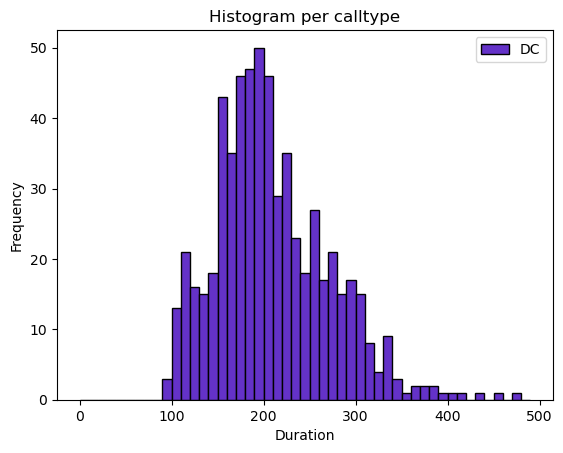

TH
# calls: 301
Minimum duration: 39.795918367346935 ms
Maximum duration: 110.86167800453514 ms


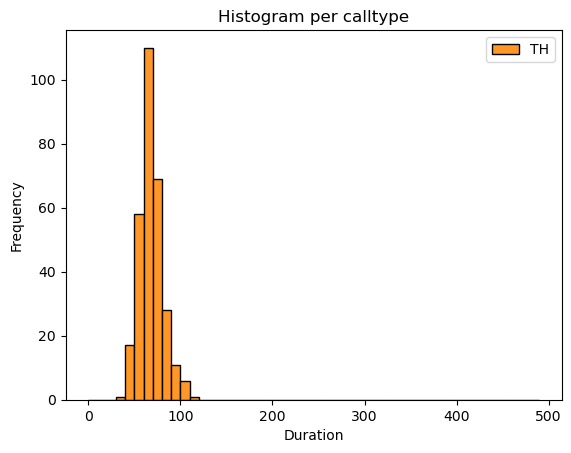

TE
# calls: 613
Minimum duration: 54.78458049886621 ms
Maximum duration: 165.6235827664399 ms


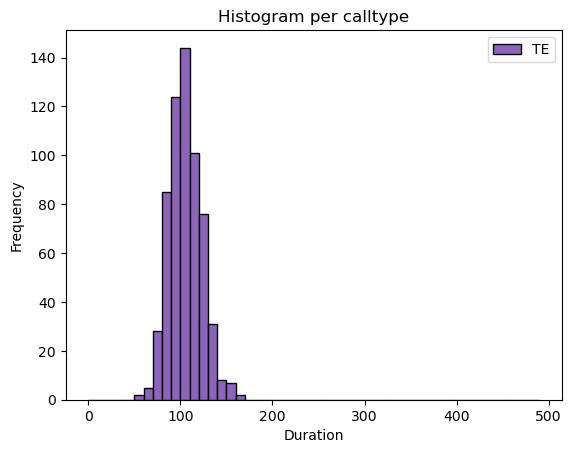

In [3]:
# plot the histogram of duration per calltype
call_types_uniq = list(set(vocListFilesT['calltype']))
BinSeq = np.arange(0,500,10)
for ct in range(len(call_types_uniq)):
    Duration_local = vocListFilesT[(vocListFilesT['calltype'].isin([call_types_uniq[ct]]))]['duration']
    color = callColor.get(call_types_uniq[ct], 'black')
    plt.hist(Duration_local, bins=BinSeq, color=color, edgecolor='black', label=call_types_uniq[ct])
    print(call_types_uniq[ct])
    print('# calls:', len(Duration_local))
    print('Minimum duration:', Duration_local.min(), 'ms')
    print('Maximum duration:', Duration_local.max(), 'ms')

    # Add labels and title
    plt.xlabel('Duration')
    plt.ylabel('Frequency')
    plt.title('Histogram per calltype')

    # Show legend
    plt.legend(loc='upper right')
    
    # Show the plot
    plt.show()

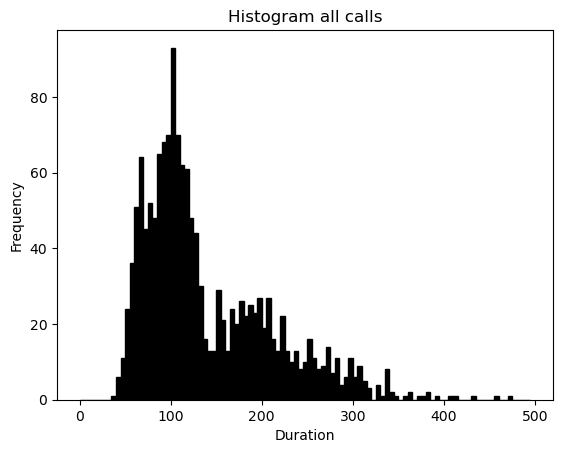

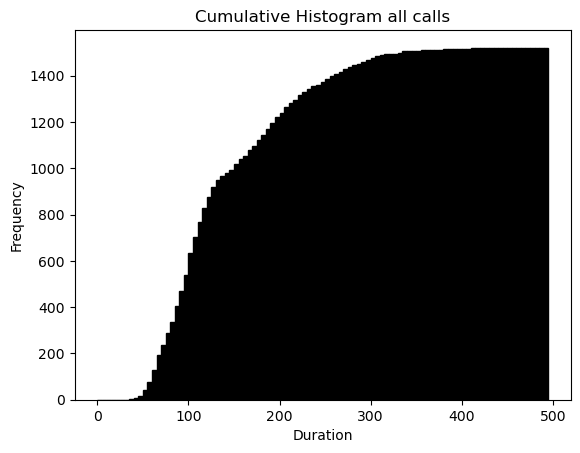

99.14529914529915 % vocalizations are shoter than 350 ms


In [4]:
# plot the histogram of duration for all selected vocalizations
BinSeq = np.arange(0,500,5)
plt.hist(vocListFilesT['duration'], bins=BinSeq, color='black', edgecolor='black')

# Add labels and title
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.title('Histogram all calls')

# Show the plot
plt.show()

plt.hist(vocListFilesT['duration'], bins=BinSeq, color='black', edgecolor='black', cumulative=True)

# Add labels and title
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.title('Cumulative Histogram all calls')
# Show the plot
plt.show()
winsize = 350 #size of the spectrogram window in ms for analysispectrogram_flat = spectrogram_cut.flatten()
PercShort = len([x for x in vocListFilesT['duration'] if x < winsize])/len(vocListFilesT['duration'])*100
print(f"{PercShort} % vocalizations are shoter than {winsize} ms")

In [5]:
# Decision on window size for the spectrogram in ms
winsize = 350
# Decision on DB Lim
DBLim = 5
print('Everything below %f DB is ignored' % DBLim)
print('All Spectrograms are increased by %f DB before ignoring all negative values =noise (set them to zeros)' % -DBLim) 

Everything below 5.000000 DB is ignored
All Spectrograms are increased by -5.000000 DB before ignoring all negative values =noise (set them to zeros)


## Collect the spectrograms for all calls

In [6]:
def get_spectro_h5(fname,DBLim = None):
    # read h5 file
    myBioSound = BioSound()
    myBioSound.readh5(fname)
    # load spectrogram
    soundSpect = np.copy(myBioSound.spectro)
    soundSpect_f = np.copy(myBioSound.fo)
    soundSpect_t = np.copy(myBioSound.to)
    # limit the dynamic range if requested
    if DBLim is not None:
        soundSpect = soundSpect - DBLim
        soundSpect[soundSpect<0] = 0
    # cut to appropriate length winsize
    duration = soundSpect.shape[1]
    if duration<winsize:
        if DBLim is None:
            spectrogram_cut = np.concatenate((soundSpect, np.ones((soundSpect.shape[0],winsize-duration))*soundSpect.min()), axis=1)
        else: 
            spectrogram_cut = np.concatenate((soundSpect, np.zeros((soundSpect.shape[0],winsize-duration))), axis=1)
    else:
        spectrogram_cut = soundSpect[:, :(winsize)]
    # flatten spectrogram
    spectrogram_flat = spectrogram_cut.flatten()
    return {"spectro": soundSpect,
            "spectro_f": soundSpect_f,
            "spectro_t": soundSpect_t,
            "spectro_flat": spectrogram_flat,
           "h5filepath": fname}

In [7]:
# -- Main --
vocSpecData = list()
for fname in vocListFilesT['h5filepath']:
    vocSpecData.append(get_spectro_h5(fname,DBLim = DBLim))
vocSpecDataT = pd.DataFrame(vocSpecData)

#### Plot a few spectrograms

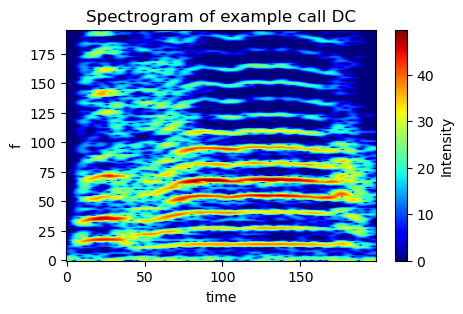

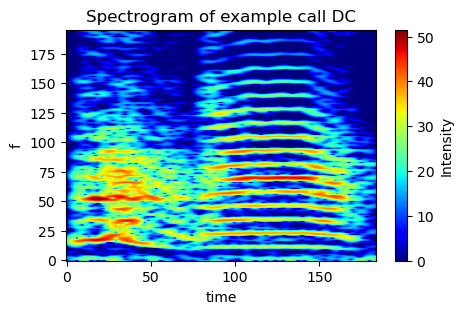

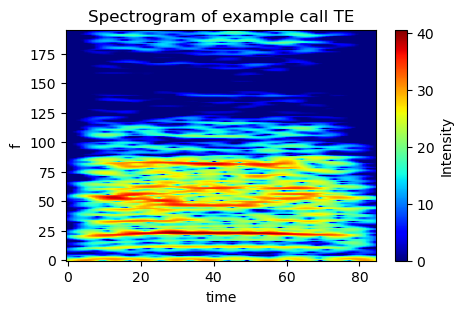

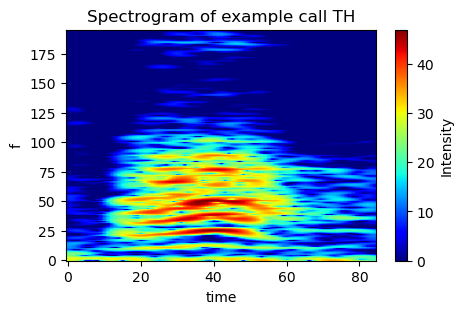

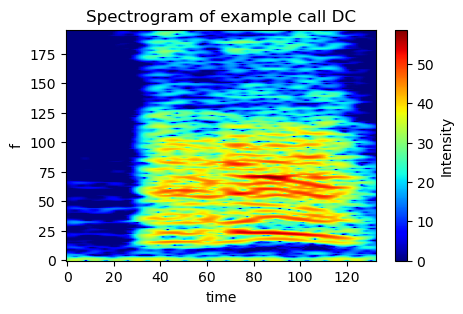

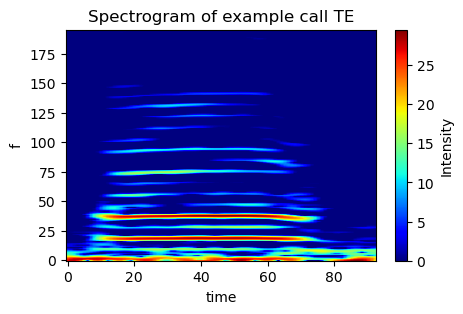

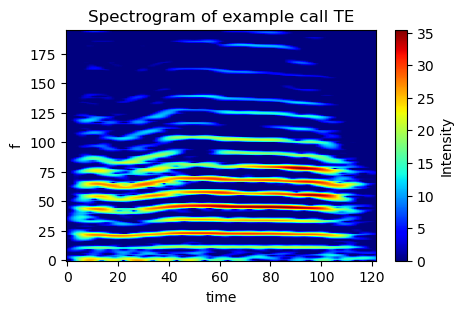

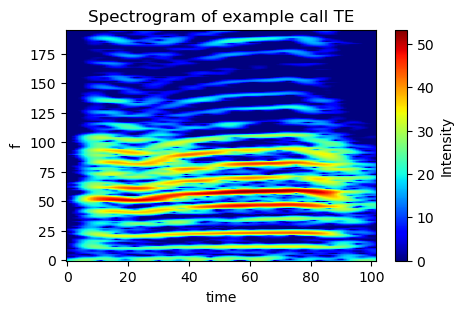

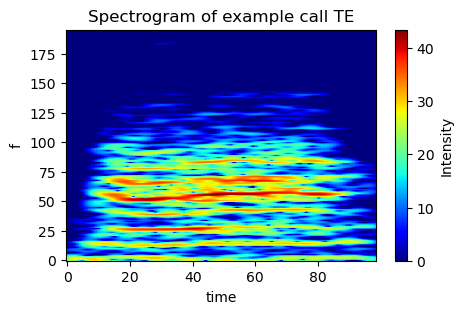

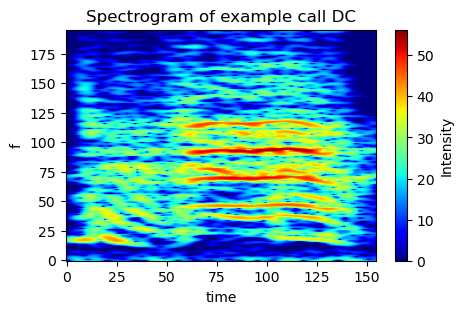

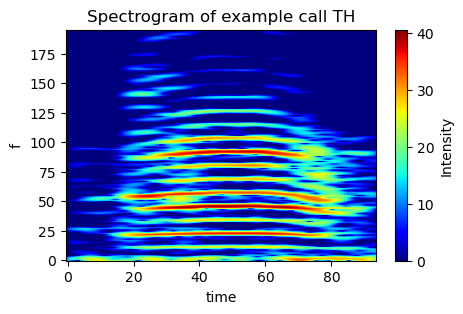

In [10]:
# plot a few call spectrograms before padding
for cc in np.arange(0,NVoc,150) :
    plt.figure(figsize=(5, 3))
    plt.imshow(vocSpecDataT['spectro'][cc], aspect='auto', origin='lower', cmap='jet')
    plt.colorbar(label='Intensity') 
    plt.title('Spectrogram of example call ' + vocListFilesT['calltype'][cc])
    plt.ylabel('f')
    plt.xlabel('time')
    plt.show()

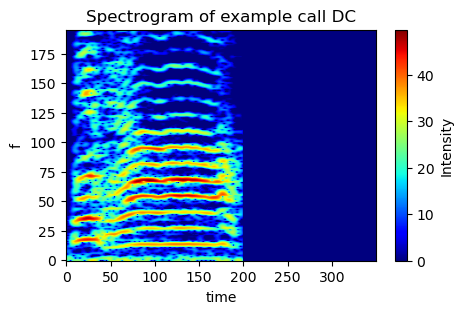

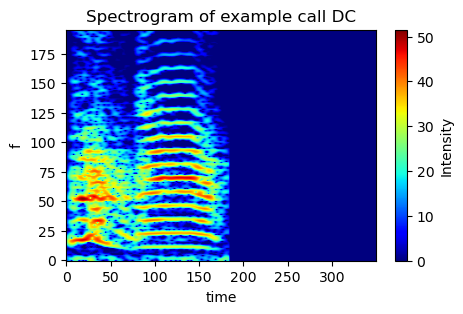

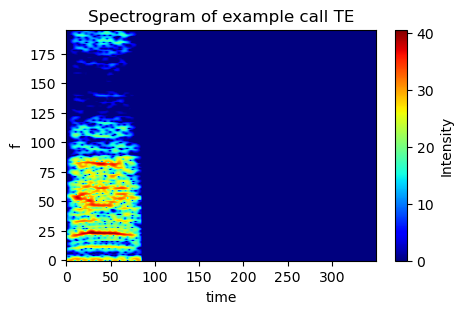

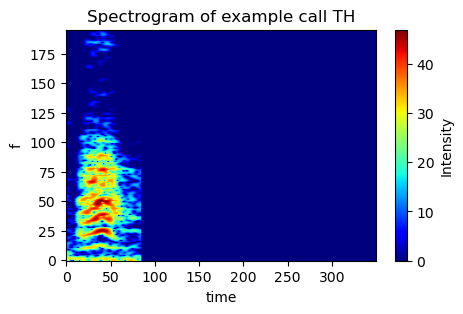

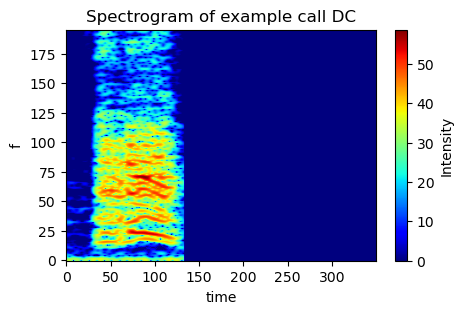

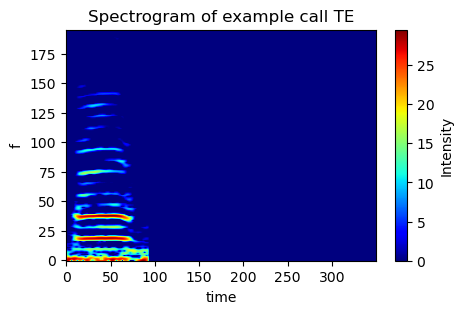

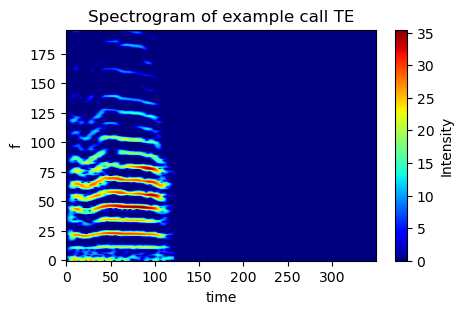

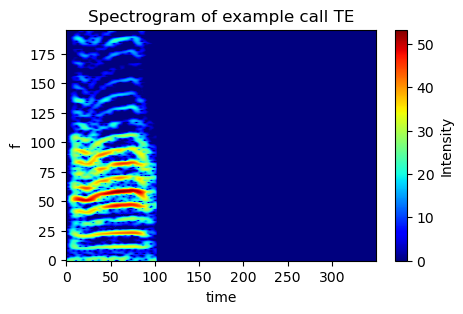

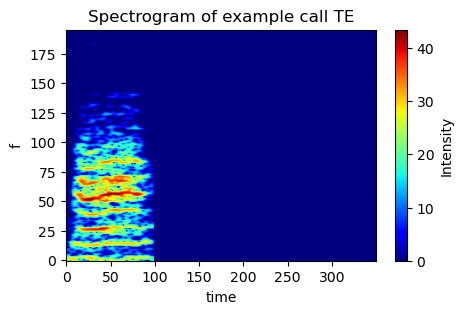

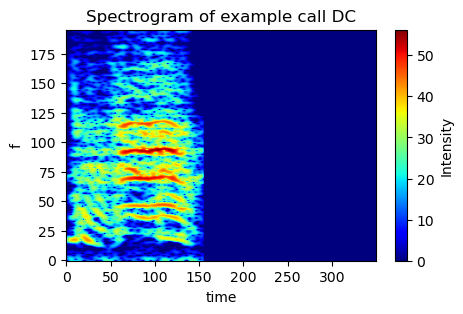

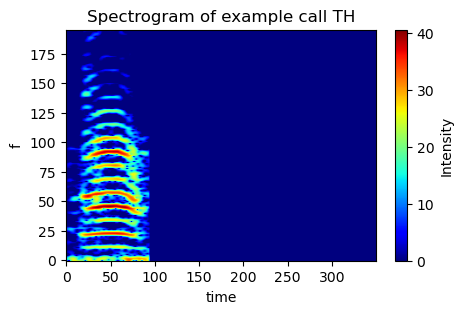

In [11]:
# plot a few call spectrograms after padding at 350ms
for cc in np.arange(0,NVoc,150) :
    plt.figure(figsize=(5, 3))
    Spectro = vocSpecDataT['spectro_flat'][cc]
    plt.imshow(Spectro.reshape(196,winsize), aspect='auto', origin='lower', cmap='jet')
    plt.colorbar(label='Intensity') 
    plt.title('Spectrogram of example call ' + vocListFilesT['calltype'][cc])
    plt.ylabel('f')
    plt.xlabel('time')
    plt.show()

In [12]:
# Extract spectrograms of all calls
X_all = np.vstack(vocSpecDataT.spectro_flat.values)
X_all[np.isinf(X_all)] = np.nan  # Convert inf to NaN to handle them together
X_all = np.nan_to_num(X_all, nan=0)

## Run a PCA on all calls' spectrograms and then an LDA to classify DC vs TE in the PCA space 

#### Optimize the number of dimensions in the PCA to obtain the best classification performance in cross validation

In [13]:

# optimize calculations to find the best number of dimensions of the PCA for optimal LDA classification in cross validation (leave one vocalizer out)
DCvsTE_ct = vocListFilesT[vocListFilesT['calltype'].isin(['DC', 'TE'])] 
y = DCvsTE_ct.calltype.values # this is the call-type values for DC and TE calls only
Dims = np.arange(1,4,1)
Dims = np.append(Dims, np.arange(5,100,5))
PCLDA_performance = list()
PCLDA_logPosterior = list()
PCLDA_VarExp = list()
for dim in Dims:
    # run a PCA with dim dimensions on all the dataset
    print('running PCA with %d dimensions' % dim)
    pca = PCA(n_components=dim)
    pca.fit(X_all)
    X_all_r = pca.transform(X_all)
    print ('Variance explained is %.2f%%' % (sum(pca.explained_variance_ratio_)*100.0))
    PCLDA_VarExp.append(sum(pca.explained_variance_ratio_)*100.0)

    # Initialize and fit LDA on DC vs TE in that PC space
    Xr = X_all_r[vocListFilesT['calltype'].isin(['DC', 'TE'])]
    lda = LinearDiscriminantAnalysis(solver='svd', shrinkage = None, priors = [0.5, 0.5])
    LOO = list()
    LOO2 = list()
    for bb in set(DCvsTE_ct.birdname):
        Xr_train =Xr[~DCvsTE_ct['birdname'].isin([bb])]
        y_train = y[~DCvsTE_ct['birdname'].isin([bb])]
        lda.fit(Xr_train, y_train)
        # append the posterior log probability of correct classification for all vocalizations belonging to the first class
        Indices0 = DCvsTE_ct['birdname'].isin([bb]) & DCvsTE_ct['calltype'].isin([lda.classes_[0]])
        if sum(Indices0):
            LOO.append(lda.predict_log_proba(Xr[Indices0])[:,0])
        # append the posterior log probability of correct classification for all vocalizations belonging to the second class
        Indices1 = DCvsTE_ct['birdname'].isin([bb]) & DCvsTE_ct['calltype'].isin([lda.classes_[1]])
        if sum(Indices1):
            LOO.append(lda.predict_log_proba(Xr[Indices1])[:,1])
        # append the score for all vocalizations
        LOO2.append(lda.predict(Xr[DCvsTE_ct['birdname'].isin([bb])]) == y[DCvsTE_ct['birdname'].isin([bb])])
    LOO = np.concatenate(LOO)
    PCLDA_logPosterior.append(sum(LOO))
    LOO2 = np.concatenate(LOO2)
    PCLDA_performance.append(sum(LOO2)/len(LOO2)*100)
    print("posterior log probability of the DC vs TE PCLDA in leave one vocalizer out cross validation:%f" % (sum(LOO)))
    print("score of the DC vs TE PCLDA in leave one vocalizer out cross validation:%f%%" % (sum(LOO2)/len(LOO2)*100))
 

running PCA with 1 dimensions
Variance explained is 36.35%
posterior log probability of the DC vs TE PCLDA in leave one vocalizer out cross validation:-116.798347
score of the DC vs TE PCLDA in leave one vocalizer out cross validation:96.065574%
running PCA with 2 dimensions
Variance explained is 43.97%
posterior log probability of the DC vs TE PCLDA in leave one vocalizer out cross validation:-109.686774
score of the DC vs TE PCLDA in leave one vocalizer out cross validation:96.803279%
running PCA with 3 dimensions
Variance explained is 47.57%
posterior log probability of the DC vs TE PCLDA in leave one vocalizer out cross validation:-102.078099
score of the DC vs TE PCLDA in leave one vocalizer out cross validation:97.131148%
running PCA with 5 dimensions
Variance explained is 52.86%
posterior log probability of the DC vs TE PCLDA in leave one vocalizer out cross validation:-126.252111
score of the DC vs TE PCLDA in leave one vocalizer out cross validation:96.311475%
running PCA with

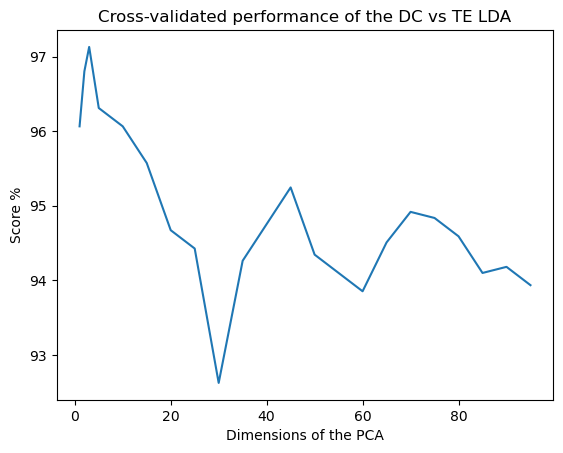

Maximum performance of LDA in cross-validation observed for the following dimensions:
[3]


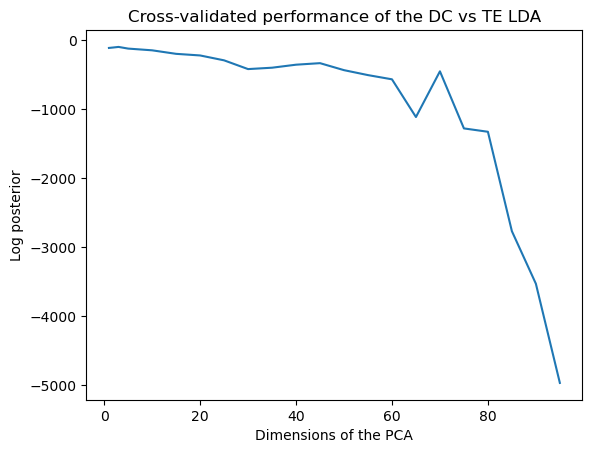

Maximum performance of LDA in cross-validation observed for the following dimensions:
[3]
Variance explained in the full dataset by the # of dimensions that provide the best classification perfromance of DC vs TE
[47.56857323]


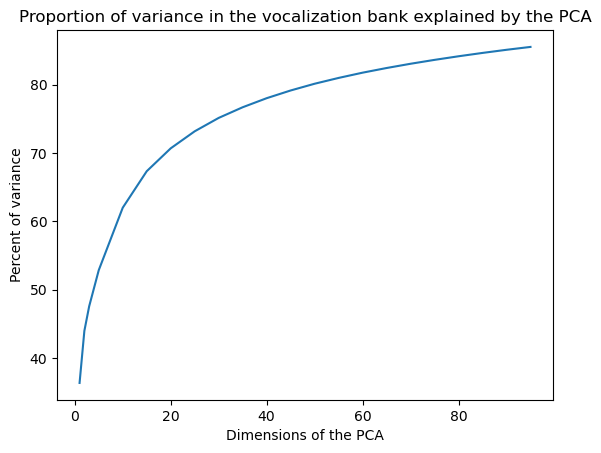

In [14]:
plt.plot(Dims, PCLDA_performance)
plt.xlabel('Dimensions of the PCA')
plt.title('Cross-validated performance of the DC vs TE LDA')
plt.ylabel('Score %')
plt.show()
print('Maximum performance of LDA in cross-validation observed for the following dimensions:')
print(Dims[PCLDA_performance == max(PCLDA_performance)])

plt.plot(Dims, PCLDA_logPosterior)
plt.xlabel('Dimensions of the PCA')
plt.title('Cross-validated performance of the DC vs TE LDA')
plt.ylabel('Log posterior')
plt.show()
print('Maximum performance of LDA in cross-validation observed for the following dimensions:')
print(Dims[PCLDA_logPosterior == max(PCLDA_logPosterior)])

plt.plot(Dims, PCLDA_VarExp)
plt.xlabel('Dimensions of the PCA')
plt.ylabel('Percent of variance')
plt.title('Proportion of variance in the vocalization bank explained by the PCA')
plt.show
print('Variance explained in the full dataset by the # of dimensions that provide the best classification perfromance of DC vs TE')
print(np.array(PCLDA_VarExp)[PCLDA_performance == max(PCLDA_performance)])

#### Use all the data to calculate the acoustic axis for DC vs Te with the optimized # of PC

In [74]:
# rerun the PCLDA with the chosen optimized number of dimensions
# first the PCA
Dim = Dims[PCLDA_performance == max(PCLDA_performance)][-1]

# Overwriting with Dim = 15 - the best result for Te vs Th and no cost here.
# This way we have the same acoustic space in both cases.
Dim = 15

print('running PCA with %d dimensions' % Dim)
pca = PCA(n_components=Dim)
pca.fit(X_all)
X_all_r = pca.transform(X_all)
print ('Variance explained is %.2f%%' % (sum(pca.explained_variance_ratio_)*100.0))

# then initialize and fit LDA on DC vs TE
lda = LinearDiscriminantAnalysis(solver='svd', shrinkage = None, priors = [0.5, 0.5])
Xr = X_all_r[vocListFilesT['calltype'].isin(['DC', 'TE'])]
DCvsTE_ct = vocListFilesT[vocListFilesT['calltype'].isin(['DC', 'TE'])] 
y = DCvsTE_ct.calltype.values # this is the call-type values for DC and TE calls only
lda.fit(Xr, y)
print(lda.get_params())
print("score of the DC vs TE lda (regularized but not CV)")
print(lda.score(Xr,y))

running PCA with 15 dimensions
Variance explained is 67.34%
{'covariance_estimator': None, 'n_components': None, 'priors': [0.5, 0.5], 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001}
score of the DC vs TE lda (regularized but not CV)
0.9811475409836066


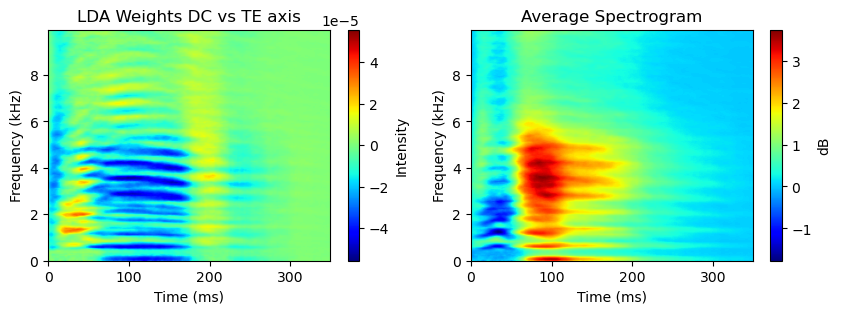

In [75]:
# Calculate the weights of the LDA in the spectrogram space
weights = np.dot(lda.scalings_.T, pca.components_)
lda_xbar = np.dot(lda.xbar_.T, pca.components_)


spectro_coefs_TEvsDC = weights.reshape(196, winsize)

# Plot as a spectrogram
plt.figure(figsize=(10, 3))

plt.subplot(1,2,1)
maxW = np.max((np.abs(spectro_coefs_TEvsDC.max()), np.abs(spectro_coefs_TEvsDC.min())))

ex = (vocSpecDataT.spectro_t[0][0], vocSpecDataT.spectro_t[0][1] * spectro_coefs_TEvsDC.shape[1]*1000, vocSpecDataT.spectro_f[0].min(), vocSpecDataT.spectro_f[0].max()/1000)
plt.imshow(spectro_coefs_TEvsDC, aspect='auto', origin='lower', cmap='jet',extent=ex, vmin = -maxW, vmax = maxW )
plt.colorbar(label='Intensity') 
plt.title('LDA Weights DC vs TE axis')
plt.ylabel('Frequency (kHz)')
plt.xlabel('Time (ms)')

plt.subplot(1,2,2)
plt.imshow(lda_xbar.reshape(196,winsize), aspect='auto', origin='lower', cmap='jet',extent=ex )
plt.colorbar(label='dB') 
plt.title('Average Spectrogram')
plt.ylabel('Frequency (kHz)')
plt.xlabel('Time (ms)')

plt.show()

In [ ]:
# Saving the lda results
ldaResTEvsDC = {'ldaWeights': weights, 'spectroMean': pca.mean_,
                 'ldaMean' : lda_xbar, 'ldaIntercept' : lda.intercept_, 
                 'nf': 196, 'nt': winsize}

saveFile = SAVEDIR + '/ldaTEvsDC.pkl'
with open(saveFile, 'wb') as f:
    pk.dump(ldaResTEvsDC, f)


In [77]:
normValue = np.sqrt(np.dot(weights,weights.T))
print(np.sqrt(np.dot(weights/normValue, weights.T/normValue)))
print(weights.max())
print(weights.min())
print(normValue)

[[1.]]
3.431707425306903e-05
-5.5585332690344224e-05
[[0.00309489]]


In [ ]:
# calculate the normalized projection values of all calls on the DCvsTE LDA axis
normValue = np.sqrt(np.dot(lda.coef_,lda.coef_.T))
#X_lda = np.dot(X_all_r - lda.xbar_, lda.coef_.T/normValue) + lda.intercept_/normValue 
X_lda = np.dot(X_all_r, lda.coef_.T/normValue) + lda.intercept_/normValue 
vocListFilesT['Xlda_DCvsTE'] = X_lda

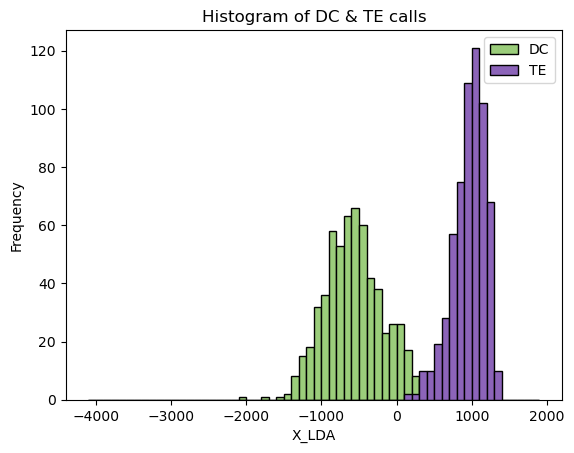

In [58]:
# Create the histogram of projected values for DC and TE
BinSeq = np.arange(-4100,2000,100)
color = call_type_colors.get('DC', 'black')  # Default to black if label not in the dictionary
plt.hist(vocListFilesT[vocListFilesT['calltype'].isin(['DC'])]['Xlda_DCvsTE'], color=color,bins= BinSeq, edgecolor='black', label='DC')
color = call_type_colors.get('TE', 'black')  # Default to black if label not in the dictionary
plt.hist(vocListFilesT[vocListFilesT['calltype'].isin(['TE'])]['Xlda_DCvsTE'], color=color,bins= BinSeq, edgecolor='black', label='TE')

# Add labels and title
plt.xlabel('X_LDA')
plt.ylabel('Frequency')
plt.title('Histogram of DC & TE calls')

# Show legend
plt.legend(loc='upper right')

# Show the plot
plt.show()

## Run a PCA on all calls' spectrograms and then an LDA to classify TE vs TH in the PCA space 

#### Optimize the number of dimensions in the PCA to obtain the best classification performance in cross validation

In [59]:

# optimize calculations to find the best number of dimensions of the PCA for optimal LDA classification in cross validation (leave one vocalizer out)
THvsTE_ct = vocListFilesT[vocListFilesT['calltype'].isin(['TH', 'TE'])] 
y = THvsTE_ct.calltype.values # this is the call-type values for TH and TE calls only
Dims = np.arange(1,4,1)
Dims = np.append(Dims, np.arange(5,100,5))
PCLDA_performance = list()
PCLDA_logPosterior = list()
PCLDA_VarExp = list()
for dim in Dims:
    # run a PCA with dim dimensions on all the dataset
    print('running PCA with %d dimensions' % dim)
    pca = PCA(n_components=dim)
    pca.fit(X_all)
    X_all_r = pca.transform(X_all)
    print ('Variance explained is %.2f%%' % (sum(pca.explained_variance_ratio_)*100.0))
    PCLDA_VarExp.append(sum(pca.explained_variance_ratio_)*100.0)

    # Initialize and fit LDA on DC vs TE in that PC space
    Xr = X_all_r[vocListFilesT['calltype'].isin(['TH', 'TE'])]
    lda = LinearDiscriminantAnalysis(solver='svd', shrinkage = None, priors = [0.5, 0.5])
    LOO = list()
    LOO2 = list()
    for bb in set(THvsTE_ct.birdname):
        Xr_train =Xr[~THvsTE_ct['birdname'].isin([bb])]
        y_train = y[~THvsTE_ct['birdname'].isin([bb])]
        lda.fit(Xr_train, y_train)
        # append the posterior log probability of correct classification for all vocalizations belonging to the first class
        Indices0 = THvsTE_ct['birdname'].isin([bb]) & THvsTE_ct['calltype'].isin([lda.classes_[0]])
        if sum(Indices0):
            LOO.append(lda.predict_log_proba(Xr[Indices0])[:,0])
        # append the posterior log probability of correct classification for all vocalizations belonging to the second class
        Indices1 = THvsTE_ct['birdname'].isin([bb]) & THvsTE_ct['calltype'].isin([lda.classes_[1]])
        if sum(Indices1):
            LOO.append(lda.predict_log_proba(Xr[Indices1])[:,1])
        # append the score for all vocalizations
        LOO2.append(lda.predict(Xr[THvsTE_ct['birdname'].isin([bb])]) == y[THvsTE_ct['birdname'].isin([bb])])
    LOO = np.concatenate(LOO)
    PCLDA_logPosterior.append(sum(LOO))
    LOO2 = np.concatenate(LOO2)
    PCLDA_performance.append(sum(LOO2)/len(LOO2)*100)
    print("posterior log probability of the TH vs TE PCLDA in leave one vocalizer out cross validation:%f" % (sum(LOO)))
    print("score of the TH vs TE PCLDA in leave one vocalizer out cross validation:%f%%" % (sum(LOO2)/len(LOO2)*100))
 

running PCA with 1 dimensions
Variance explained is 36.35%
posterior log probability of the TH vs TE PCLDA in leave one vocalizer out cross validation:-642.095246
score of the TH vs TE PCLDA in leave one vocalizer out cross validation:53.282276%
running PCA with 2 dimensions
Variance explained is 43.97%
posterior log probability of the TH vs TE PCLDA in leave one vocalizer out cross validation:-559.773237
score of the TH vs TE PCLDA in leave one vocalizer out cross validation:64.660832%
running PCA with 3 dimensions
Variance explained is 47.57%
posterior log probability of the TH vs TE PCLDA in leave one vocalizer out cross validation:-518.677133
score of the TH vs TE PCLDA in leave one vocalizer out cross validation:69.146608%
running PCA with 5 dimensions
Variance explained is 52.86%
posterior log probability of the TH vs TE PCLDA in leave one vocalizer out cross validation:-267.941547
score of the TH vs TE PCLDA in leave one vocalizer out cross validation:88.183807%
running PCA with

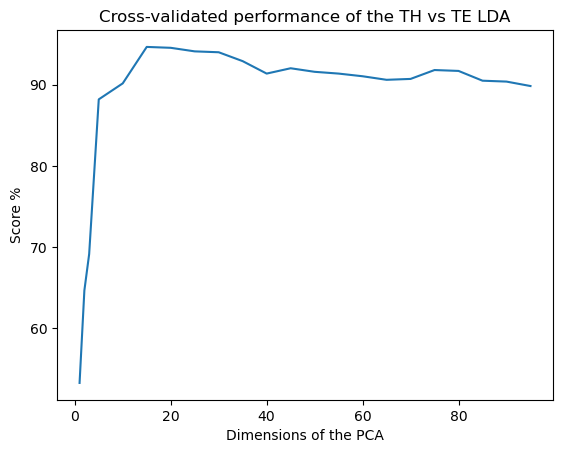

Maximum performance of LDA in cross-validation observed for the following dimensions:
[15]


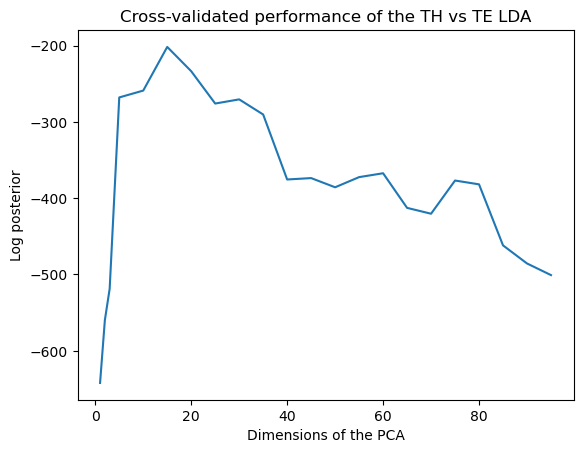

Maximum performance of LDA in cross-validation observed for the following dimensions:
[15]
Variance explained in the full dataset by the # of dimensions that provide the best classification perfromance of TH vs TE
[67.3435124]


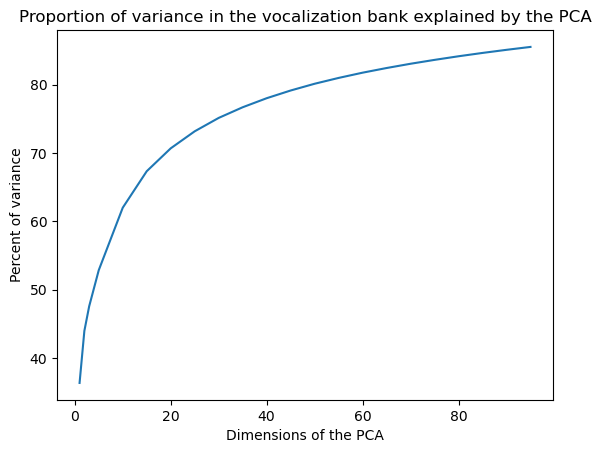

In [60]:
plt.plot(Dims, PCLDA_performance)
plt.xlabel('Dimensions of the PCA')
plt.title('Cross-validated performance of the TH vs TE LDA')
plt.ylabel('Score %')
plt.show()
print('Maximum performance of LDA in cross-validation observed for the following dimensions:')
print(Dims[PCLDA_performance == max(PCLDA_performance)])

plt.plot(Dims, PCLDA_logPosterior)
plt.xlabel('Dimensions of the PCA')
plt.title('Cross-validated performance of the TH vs TE LDA')
plt.ylabel('Log posterior')
plt.show()
print('Maximum performance of LDA in cross-validation observed for the following dimensions:')
print(Dims[PCLDA_logPosterior == max(PCLDA_logPosterior)])

plt.plot(Dims, PCLDA_VarExp)
plt.xlabel('Dimensions of the PCA')
plt.ylabel('Percent of variance')
plt.title('Proportion of variance in the vocalization bank explained by the PCA')
plt.show
print('Variance explained in the full dataset by the # of dimensions that provide the best classification perfromance of TH vs TE')
print(np.array(PCLDA_VarExp)[PCLDA_performance == max(PCLDA_performance)])

#### Use all the data to calculate the acoustic axis for TH vs Te with the optimized # of PC

In [78]:
# rerun the PCLDA with the chosen optimized number of dimensions
# first the PCA
Dim = Dims[PCLDA_performance == max(PCLDA_performance)][-1]

# Overwriting with Dim = 15 - the best result for Te vs Th and no cost here.
# This way we have the same acoustic space in both cases.
Dim = 15

print('running PCA with %d dimensions' % Dim)
pca = PCA(n_components=Dim)
pca.fit(X_all)
X_all_r = pca.transform(X_all)
print ('Variance explained is %.2f%%' % (sum(pca.explained_variance_ratio_)*100.0))

# then initialize and fit LDA on TH vs TE
lda = LinearDiscriminantAnalysis(solver='svd', shrinkage = None, priors = [0.5, 0.5])
Xr = X_all_r[vocListFilesT['calltype'].isin(['TH', 'TE'])]
THvsTE_ct = vocListFilesT[vocListFilesT['calltype'].isin(['TH', 'TE'])] 
y = THvsTE_ct.calltype.values # this is the call-type values for DC and TE calls only
lda.fit(Xr, y)
print(lda.get_params())
print("score of the TH vs TE lda (regularized but not CV)")
print(lda.score(Xr,y))

running PCA with 15 dimensions
Variance explained is 67.34%
{'covariance_estimator': None, 'n_components': None, 'priors': [0.5, 0.5], 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001}
score of the TH vs TE lda (regularized but not CV)
0.9573304157549234


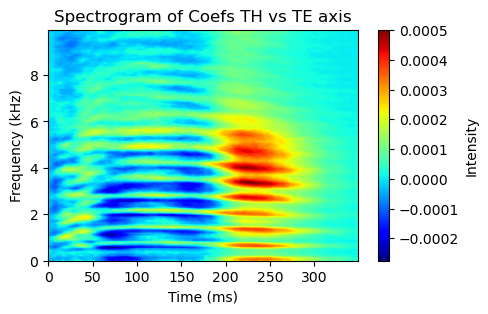

In [79]:
weights = np.dot(lda.scalings_.T, pca.components_)
lda_xbar = np.dot(lda.xbar_.T, pca.components_)

spectro_coefs_TEvsTH = weights.reshape(196, winsize)

# Plot as a spectrogram
vocSpecDataT.spectro_f[0][0]
plt.figure(figsize=(5, 3))

ex = (vocSpecDataT.spectro_t[0][0], vocSpecDataT.spectro_t[0][1] * spectro_coefs_TEvsTH.shape[1]*1000, vocSpecDataT.spectro_f[0].min(), vocSpecDataT.spectro_f[0].max()/1000)
plt.imshow(spectro_coefs_TEvsTH, aspect='auto', origin='lower', cmap='jet',extent=ex)
plt.colorbar(label='Intensity') 
plt.title('Spectrogram of Coefs TH vs TE axis')
plt.ylabel('Frequency (kHz)')
plt.xlabel('Time (ms)')
plt.show()

In [63]:
# Saving the lda results
ldaResTEvsTH = {'ldaWeights': weights, 'spectroMean': pca.mean_,
                 'ldaMean' : lda_xbar, 'ldaIntercept' : lda.intercept_, 
                 'nf': 196, 'nt': winsize}

saveFile = SAVEDIR + '/ldaTEvsTH.pkl'
with open(saveFile, 'wb') as f:
    pk.dump(ldaResTEvsTH, f)


In [80]:
normValue = np.sqrt(np.dot(weights, weights.T))

In [81]:
print(normValue)
print(np.sqrt(np.dot(weights/normValue, weights.T/normValue)))
print(weights.max())
print(weights.min())

[[0.03204344]]
[[1.]]
0.0005011126283553124
-0.0002754378362240346


In [66]:
# calculate the normalized projection values of all calls on the THvsTE LDA axis
normValue = np.sqrt(np.sum(lda.coef_*lda.coef_))
# X_lda = np.dot(X_all_r - lda.xbar_, lda.coef_.T/normValue) + lda.intercept_/normValue 
X_lda = np.dot(X_all_r, lda.coef_.T/normValue) + lda.intercept_/normValue 
vocListFilesT['Xlda_THvsTE'] = X_lda

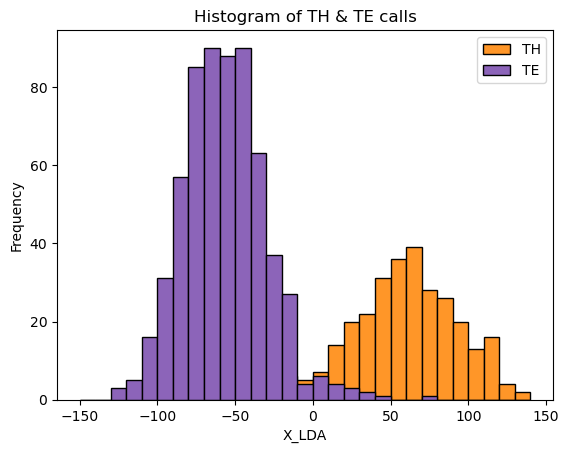

In [68]:
# Create the histogram of projected values for TH and TE
BinSeq = np.arange(-150,150,10)
color = call_type_colors.get('TH', 'black')  # Default to black if label not in the dictionary
plt.hist(vocListFilesT[vocListFilesT['calltype'].isin(['TH'])]['Xlda_THvsTE'],bins= BinSeq, color=color, edgecolor='black', label='TH')
color = call_type_colors.get('TE', 'black')  # Default to black if label not in the dictionary
plt.hist(vocListFilesT[vocListFilesT['calltype'].isin(['TE'])]['Xlda_THvsTE'],bins= BinSeq, color=color, edgecolor='black', label='TE')

# Add labels and title
plt.xlabel('X_LDA')
plt.ylabel('Frequency')
plt.title('Histogram of TH & TE calls')

# Show legend
plt.legend(loc='upper right')

# Show the plot
plt.show()